In [1]:
import dfBasics
import common
import encoder
import pfAdapt
import charts


Setup Complete


In [2]:
import pandas as pd
from pyspark.sql import functions

# Lib functions

# Main

In [3]:
columns = ['CGLOBALMESSAGEID', 'CSTARTTIME', 'CENDTIME', 'CSTATUS', 'CSERVICE',\
       'CSLABILLINGMONTH', 'CSENDERPROTOCOL', 'CSENDERENDPOINTID',\
       'CINBOUNDSIZE', 'CRECEIVERPROTOCOL', 'CRECEIVERENDPOINTID', 'CSLATAT',\
       'CMESSAGETAT2', 'CSLADELIVERYTIME']
# withot 'CSLABILLINGMONTH'
def get_columns_2():
    columns = ['CGLOBALMESSAGEID', 'CSTARTTIME', 'CENDTIME', 'CSTATUS', 'CSERVICE',\
            'CSENDERPROTOCOL', 'CSENDERENDPOINTID',\
           'CINBOUNDSIZE', 'CRECEIVERPROTOCOL', 'CRECEIVERENDPOINTID', 'CSLATAT',\
           'CMESSAGETAT2', 'CSLADELIVERYTIME']
    return columns
columns = get_columns_2()
#to count messages sent
#columns = [ 'CSTARTTIME', 'CSENDERENDPOINTID']

In [5]:
sparkSession = dfBasics.getSparkSession()

In [ ]:
df = sparkSession.read.parquet('hdfs://172.30.17.145:8020/sla_sql_data/*/*').select(columns).dropDuplicates()  

In [6]:
df = sparkSession.read.parquet('hdfs://172.30.17.145:8020/sla_sql_data/159041*/*').select(columns).dropDuplicates() 

In [ ]:
columns = df.limit(1).toPandas().columns

In [ ]:
df.limit(1).head()

In [4]:
# read timestamps from file
with open("/tmp/slatimestamps.txt", "r") as file:
    lines = file.read().split('\n')

In [7]:
df = sparkSession.read.parquet('hdfs://172.30.17.145:8020/sla_sql_data/' + lines[0] +  '*/*').select(columns).dropDuplicates() 

In [ ]:
len(lines)

In [ ]:
!ls -a /home/jovyan
#!touch ~/.hdfscli.cfg
#!rm /home/jovyan/.hdfscli.cfg
!more /home/jovyan/.hdfscli.cfg

# Create Encoder

In [ ]:
withoutColumns = ['CSTARTTIME', 'CENDTIME','CINBOUNDSIZE', 'CSLATAT', 'CMESSAGETAT2', 'CSLADELIVERYTIME']
columns = columns[~columns.isin(withoutColumns)]

In [ ]:
encoder.createEncoders

In [ ]:
for column in columns:
    print(column)
    df4 = df.select(column).dropDuplicates().toPandas() 
    df4[column] = df4[column].astype(str)
    encoder.createEncoders(df4,[column])

# Functions

In [ ]:
def dfcolumnSeries(column):
    return df.select(column).dropDuplicates()
def dfcolumnCount(column):
    return dfcolumnSeries(column).count()

In [ ]:
from functools import reduce
import operator

def eval1(filteredrows):
    element = staticfeatureset.index[0]
    res = filteredrows[element].eq(staticfeatureset[element])

    for element in staticfeatureset.index:
        res = reduce(operator.and_,(res,filteredrows[element].eq(staticfeatureset[element])))
    return res

In [ ]:
# find out variable columns and type of value
from pyspark.sql.functions import col

selected = ['timestamp', 'value','year','month', 'day', 'hour', 'minute']

def getDFvalueWithHash(currenthash):
    pfm = df.filter(col("hashvalue") == currenthash) \
            .withColumn('value', col('value').cast('int'))\
            .select(selected).toPandas().sort_values('timestamp').reset_index() 
    return pfm

def getDFvalueWithHashSchema(schemaid,currenthash):
    pfm = df.filter(col("hashvalue") == currenthash) \
            .filter(col("schemaid") == schemaid) \
            .withColumn('value', col('value').cast('int'))\
            .select(selected).toPandas().sort_values('timestamp').reset_index() 
    return pfm

def getIgroupHashes(igroup):
        return df.filter(col("igroup") == igroup).select(["hashvalue"]).dropDuplicates().toPandas()['hashvalue']

In [ ]:
# remove columns which are variable to find related metrics
def getStaticFeatures(_hash):
    allcolumns = filteredrows[filteredrows['hashvalue'] == _hash].columns
    skipcolumns = ['timestamp', 'value',  'hashvalue', 'igroup', 'inode', 'year', 'month', 'day', 'hour', 'minute']
    featurecolumns = allcolumns[~allcolumns.isin(skipcolumns)]
    featurecolumns = pfAdapt.getVariableUniqueColums(filteredrows[featurecolumns])
    staticfeatureset = filteredrows[filteredrows['hashvalue'] == _hash][featurecolumns].iloc[0]
    return staticfeatureset

# Info

In [ ]:
def getDFMin(column):
    row1 = df.agg({column: "min"}).collect()[0]
    return(row1["min(" + column + ")"])

def getDFMax(column):
    row1 = df.agg({column: "max"}).collect()[0]
    return(row1["max(" + column + ")"])
    
dfminStart = getDFMin("CSTARTTIME")
dfmaxStart = getDFMax("CSTARTTIME")

#dfminEnd = getDFMin("CENDTIME")
#dfmaxEnd = getDFMax("CENDTIME")

dfrowCount     = df.count()
dfcolumnCount  = len(df.columns)

#numbermessages = df.select('CGLOBALMESSAGEID').dropDuplicates().count() 

In [ ]:
def printMinMaxDate(prefix,dfminTimestamp,dfmaxTimestamp):
    print(prefix + ': min:',common.date(float(dfminTimestamp) / 1e3), 'max:', common.date(float(dfmaxTimestamp) / 1e3))
    
printMinMaxDate('CSTARTTIME', dfminStart,dfmaxStart)    
#printMinMaxDate('CENDTIME', dfminEnd,dfmaxEnd) 
print('rows#:',dfrowCount,'columns#:',dfcolumnCount)
print('messages#:',numbermessages)

In [7]:
# B Step2
#pfall = df.limit(100000).toPandas() 
pfall = df.toPandas() 

In [18]:
from datetime import time
import datetime as dt
import calendar
import pytz
de = pytz.timezone('Europe/Berlin')

# long timestamp
def date(x):
    return  dt.datetime.fromtimestamp(float(x) / 1e3, tz=de)


def adddatecolumns(data,pf,column) :
    data['year'] = pf[column].apply(lambda x: date(x).date().year)
    data['month'] = pf[column].apply(lambda x: date(x).date().month)
    data['day'] = pf[column].apply(lambda x: date(x).date().day)
    data['hour'] = pf[column].apply(lambda x: date(x).time().hour)
    data['minute'] = pf[column].apply(lambda x: date(x).time().minute)
    #data['second'] = pf[column].apply(lambda x: x.time().second)
    #data['microsecond'] = pf[column].apply(lambda x: x.time().microsecond)

def converttimestampcolumnn(pf,tsc) :
    pf[tsc] = pf[tsc].apply(lambda x: dt.datetime.fromtimestamp(float(x) / 1e3))

In [ ]:
#dt.datetime.fromtimestamp(float(pfall.iloc[0]['CSTARTTIME']) / 1e3)

#date(pfall.iloc[0]['CSTARTTIME'])
#date(1579064281477).date().year
del(pfall['year'])

In [15]:
def astype(pfall,selected,newtype):
    for each in selected:
        pfall[each] = pfall[each].astype(newtype)
        
selected =  ['CSENDERENDPOINTID']       
astype(pfall,selected,str)        


# B

In [8]:
pfall = df.toPandas() 

In [11]:
#B
selected = [ 'CSTATUS', 'CSERVICE',\
        'CSENDERPROTOCOL', 'CSENDERENDPOINTID',\
        'CRECEIVERPROTOCOL', 'CRECEIVERENDPOINTID']

astype(pfall,selected,str) 
encoder.encode(pfall,selected)
astype(pfall,['CSTARTTIME','CENDTIME','CSLATAT','CMESSAGETAT2','CSLADELIVERYTIME','CINBOUNDSIZE'] ,int) 
#del(pfall['CSLABILLINGMONTH'])
pfall['CGLOBALMESSAGEID'] = pfall['CGLOBALMESSAGEID'].apply(hash)
pfall = pfall.drop_duplicates()

KeyboardInterrupt: 

In [10]:
def getCountDF(pf,column,hashes):
    dft = pd.DataFrame(columns=[column, 'count'])
    i=0
    for hash in hashes:
        pfall=pf[pf[column] == hash]
        num=len(pfall)
        if num > 1:
            dft.loc[i] = [hash] + [num]
            i=i+1
    return dft.sort_values('count')

def usedcolumns(tb,row):
    col = []
    for column in tb.columns:
        if tb.iloc[row][column] == None :
            col.append(column)
    return col

def diffcolumns(tb):
    col = []
    for column in tb.columns:
        if tb.iloc[0][column] != tb.iloc[1][column] :
            col.append(column)
    return col

In [11]:

ac = pd.unique(pfall['CGLOBALMESSAGEID'])
tt = getCountDF(pfall,'CGLOBALMESSAGEID',ac)

In [ ]:
len(tt)
#tt[tt['count'] > 2]

In [ ]:
#len(pd.unique(pfall['CGLOBALMESSAGEID'])),len(pfall)
#tt[tt['count'] > 1]
#tt
#pfall[pfall['CGLOBALMESSAGEID'] == ac[0]]
#usedcolumns(tb,0)
#usedcolumns(tb,1)
#tb = pfall[pfall['CGLOBALMESSAGEID'] == tt.iloc[300]['CGLOBALMESSAGEID']]

  
def printtt():    
    for index, row in tt.iterrows():
        print(row['CGLOBALMESSAGEID'])
        tb = pfall[pfall['CGLOBALMESSAGEID'] == row['CGLOBALMESSAGEID']]
        print(diffcolumns(tb))
    
tb = pfall[pfall['CGLOBALMESSAGEID'] == tt.iloc[1]['CGLOBALMESSAGEID']]
tbindex = tb.index[1]
pfall.loc[tbindex]['CGLOBALMESSAGEID']
if pfall.loc[tbindex]['CSLADELIVERYTIME'] < 0 :
        print("remove " + pfall.loc[tbindex]['CGLOBALMESSAGEID'])
        pfall = pfall.drop(tbindex)


In [12]:
def printtt():    
    col = []
    for index, row in tt.iterrows():
        tb = pfall[pfall['CGLOBALMESSAGEID'] == row['CGLOBALMESSAGEID']]
        for bindex, brow in tb.iterrows():
            if pfall.loc[bindex]['CSLADELIVERYTIME'] < 0 :
                #print (str(index) + ' ' + str(bindex))
                col.append(bindex)
    return col

col = printtt()   
pfall = pfall.drop(col)

In [29]:
#pfall[pfall['CGLOBALMESSAGEID'] == tt.iloc[1]['CGLOBALMESSAGEID']]
#tt
pfall.head()
#pfall.dtypes
#
#pfall[(pfall['outcome'] == 0) & (pfall['CSTATUS'] == 'PENDING')]
#pfall[(pfall['outcome'] == 0)]

,CGLOBALMESSAGEID,CSTARTTIME,CENDTIME,CSTATUS,CSERVICE,CSENDERPROTOCOL,CSENDERENDPOINTID,CINBOUNDSIZE,CRECEIVERPROTOCOL,CRECEIVERENDPOINTID,CSLATAT,CMESSAGETAT2,CSLADELIVERYTIME,year,month,day,hour,minute,outcome
0,-5337621448928241754,1590409660592,1590409666729,SUCCESS,MAKO_BE_ROUTER,AS2,2191,479,AS2,1533,6006,6137,1590409666598,2020,5,25,14,27,0
1,2392340453842511321,1590409807451,1590409812091,SUCCESS,MaKo,AS2,1801,3161,AS2,1896,4586,4640,1590409812037,2020,5,25,14,30,0
2,-5909609811583234199,1590409816905,1590409820350,SUCCESS,MAKO_BE_ROUTER,AS2,1512,18375,AS2,2216,3250,3445,1590409820155,2020,5,25,14,30,0
3,6455585319987900692,1590409840098,1590409845480,SUCCESS,MaKo,AS2,598,193,MAIL,162,5362,5382,1590409845460,2020,5,25,14,30,0
4,-1737618413905665627,1590410116738,1590410122033,SUCCESS,MAKO_BE_ROUTER,AS2,2191,194,AS2,1533,5150,5295,1590410121888,2020,5,25,14,35,0


In [ ]:
pfall[pfall['CGLOBALMESSAGEID'] == tt.iloc[0]['CGLOBALMESSAGEID']].iloc[0]['CGLOBALMESSAGEID'], \
pfall.loc[10468]['CGLOBALMESSAGEID']


#pfall.loc[tt.loc[1]['index']]['CGLOBALMESSAGEID'], tt.loc[1]['CGLOBALMESSAGEID']
#pfall.loc[tt.loc[1]['index']], tt.loc[1]
#len(pfall)
#len(pfall['CGLOBALMESSAGEID'].drop_duplicates()), len(pfall)
#tt

In [ ]:
encoder.encode(pfall,selected)

In [16]:
selected = [  'CSENDERENDPOINTID', 'CRECEIVERENDPOINTID']

astype(pfall,selected,str) 
encoder.encode(pfall,selected)
#astype(pfall,['CSTARTTIME','CENDTIME','CSLATAT','CMESSAGETAT2','CSLADELIVERYTIME','CINBOUNDSIZE'] ,int) 
#del(pfall['CSLABILLINGMONTH'])
pfall['CGLOBALMESSAGEID'] = pfall['CGLOBALMESSAGEID'].apply(hash)
pfall = pfall.drop_duplicates()

In [19]:
# convert timestamp to datetime and add column date
#import calendar
##import pytz
#de = pytz.timezone('Europe/Berlin')
adddatecolumns(pfall,pfall,'CSTARTTIME')

In [22]:
pfall = pfall.assign(outcome=(~( ((pfall['CSTATUS'] == 'PENDING') & (pfall['CSERVICE'] == 'InvoicePortal')) | ((pfall['CSTATUS'] == 'PENDING') & (pfall['CSERVICE'] == 'IDS')) | (pfall['CSTATUS'] == 'SUCCESS') | (pfall['CSTATUS'] == 'SUCCESS_DOWNLOADED') | (pfall['CSTATUS'] == 'SUCCESS_POLLQUEUE'))).astype(int))

In [20]:
astype(pfall,['CSTARTTIME'] ,int) 

In [ ]:
#pfall.to_parquet('/tmp/msgsenders_0702.parquet', engine='fastparquet', compression='GZIP')

In [ ]:
#pd.read_parquet('/tmp/msgsenders.parquet', engine='fastparquet')

In [61]:
## Setup charts
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup Complete")

def get_ym_string(a,b) :
    return a + "-" + b
    #return a.join(["-",b]) 

def get_ym(mdcountsall) :
    a = mdcountsall.index.get_level_values(0).astype(str)
    b = mdcountsall.index.get_level_values(1).astype(str)
    return a,b

def get_ymd(mdcountsall) :
    a = mdcountsall.index.get_level_values(0).astype(str)
    b = mdcountsall.index.get_level_values(1).astype(str)
    c = mdcountsall.index.get_level_values(2).astype(str)
    return a,b,c

def get_ymd_string(a,b,c) :
    return a + "-" + b + "-" + c 

def get_ymdh(mdcountsall) :
    a = mdcountsall.index.get_level_values(0).astype(str)
    b = mdcountsall.index.get_level_values(1).astype(str)
    c = mdcountsall.index.get_level_values(2).astype(str)
    d = mdcountsall.index.get_level_values(3).astype(str)
    return a,b,c,d

def get_ymdh_string(a,b,c,d) :
    return a + "-" + b + "-" + c + "-" + d

def createData_ym(pfall,month) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['month'] == month)].groupby(['year','month'])['year'].count()
    else :
        mdcountsall = pfall.groupby(['year','month'])['year'].count()    
    a,b = get_ym(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ym_string(a,b)
    data2['outcome'] = mdcountsall.reset_index(level=0, drop=True).reset_index()['year'].astype(int) 
    return data2

def createData(pfall,month) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['month'] == month)].groupby(['year','month','day','hour'])['year'].count()
    else :
        mdcountsall = pfall.groupby(['year','month','day','hour'])['year'].count()    
    a,b,c,d = get_ymdh(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ymdh_string(a,b,c,d)
    data2['outcome'] =  mdcountsall.reset_index(level=0, drop=True).reset_index()['year'].astype(int)

    #for pivot table
    data2['hours'] =  d.astype(int) 
    data2['days']  =  c.astype(int) 
    return data2

def createData_ymd(pfall,month) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['month'] == month)].groupby(['year','month','day'])['year'].count()
    else :
        mdcountsall = pfall.groupby(['year','month','day'])['year'].count()    
    a,b,c = get_ymd(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ymd_string(a,b,c)
    data2['outcome'] = mdcountsall.reset_index(level=0, drop=True).reset_index()['year'].astype(int) 
    return data2

def label(graph,skip,rot) :
    for ind, label in enumerate(graph.get_xticklabels()):
        if ind % skip == 0:  # every 10th label is kept
            label.set_visible(True)
            label.set_rotation(rot)
        else:
            label.set_visible(False)

def createBarplot(md,fx,fy,fontscale,title="") :
    sns.set(style='whitegrid', palette='muted', font_scale=fontscale)
    plt.figure(figsize=(fx,fy))
    plt.title(title)
    ax = sns.barplot(x=md['date'], y=md['outcome'], data=md)
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=75 )
    plt.tight_layout()
    plt.show()
    return ax

## heatmap
def createHeatmap(piv,title="") :
    plt.figure(figsize=(24,8))
    plt.title(title)
    ax = sns.heatmap(piv, square=True)
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=0 )
    plt.tight_layout()
    plt.show()
    return ax

Setup Complete


In [ ]:
#pfall.head()
pfall[pfall['CGLOBALMESSAGEID'] == '2af51910-9e8b-11ea-aad1-6c31ac1e100c']

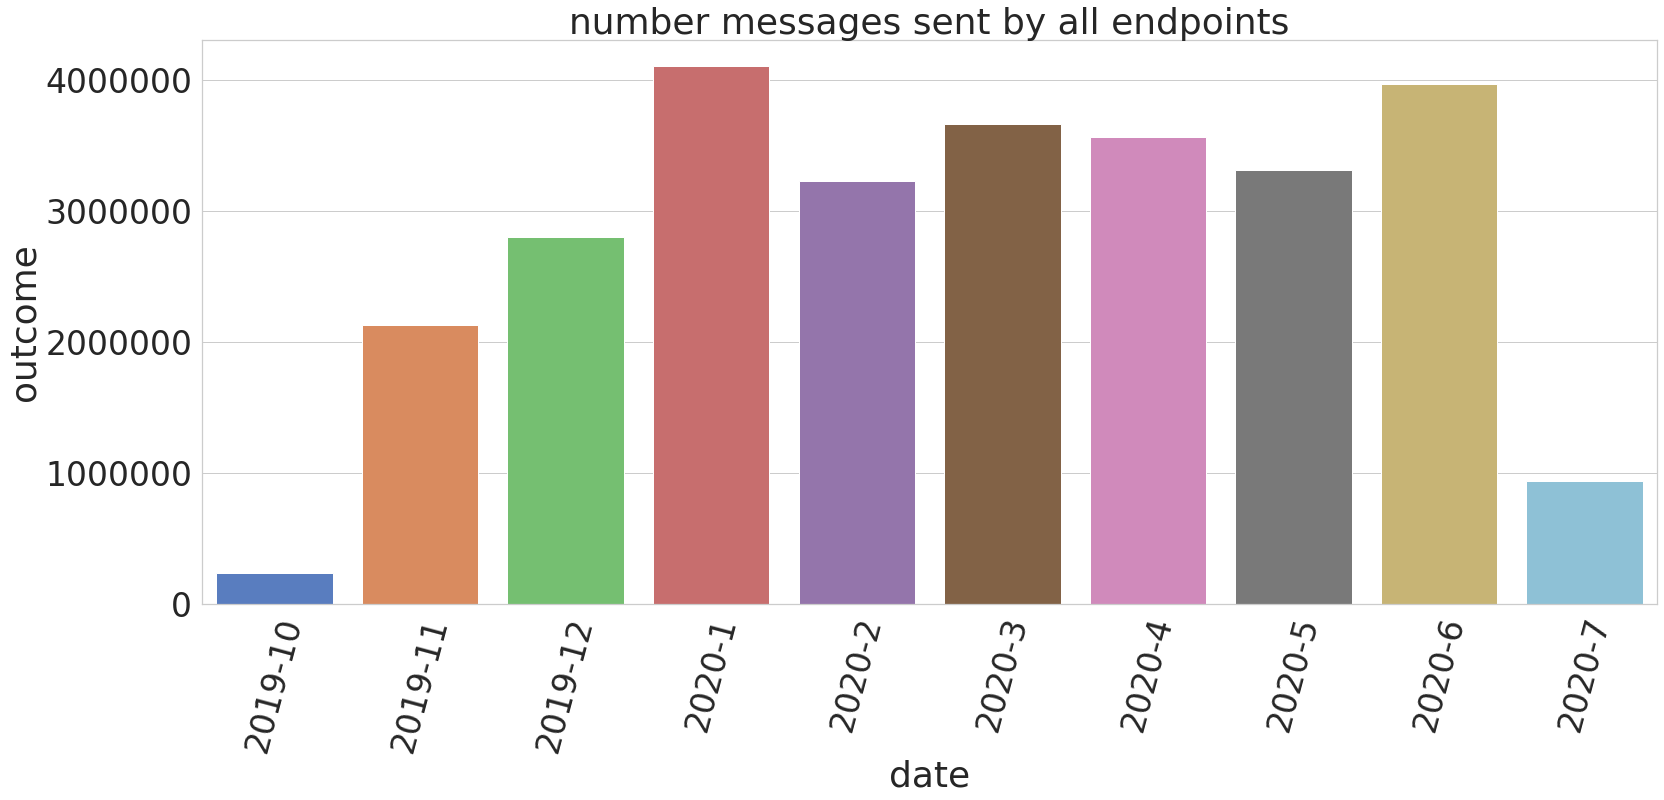

In [34]:
md = createData_ym(pfall,0)
ax=createBarplot(md,24,12,3.0,title="number messages sent by all endpoints")
#label(ax,1000,90)

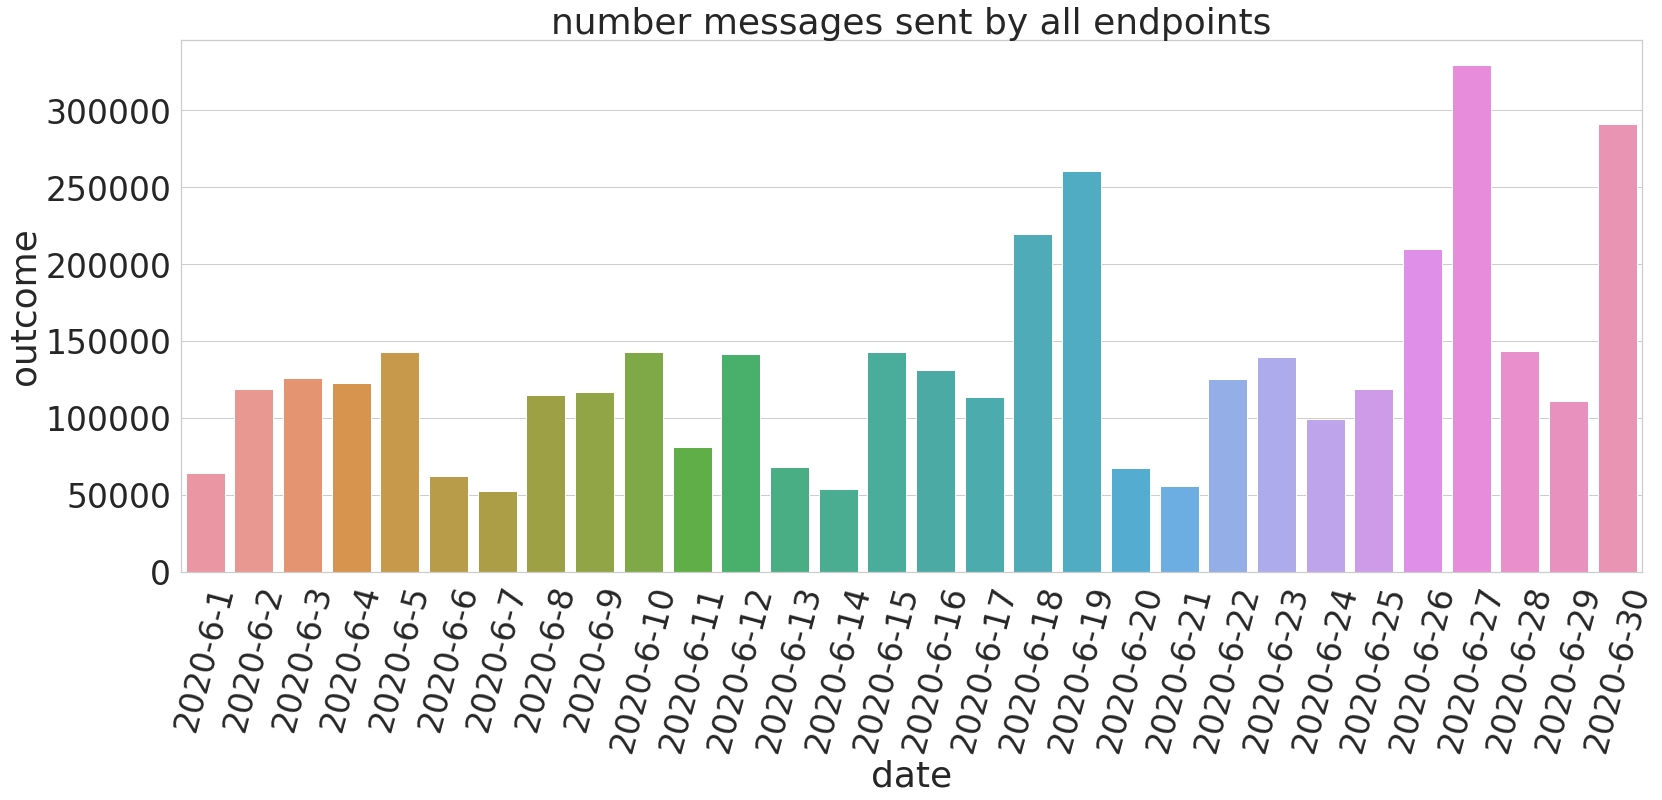

In [35]:
md = createData_ymd(pfall,6)
ax=createBarplot(md,24,12,3.0,title="number messages sent by all endpoints")
label(ax,1000,90)

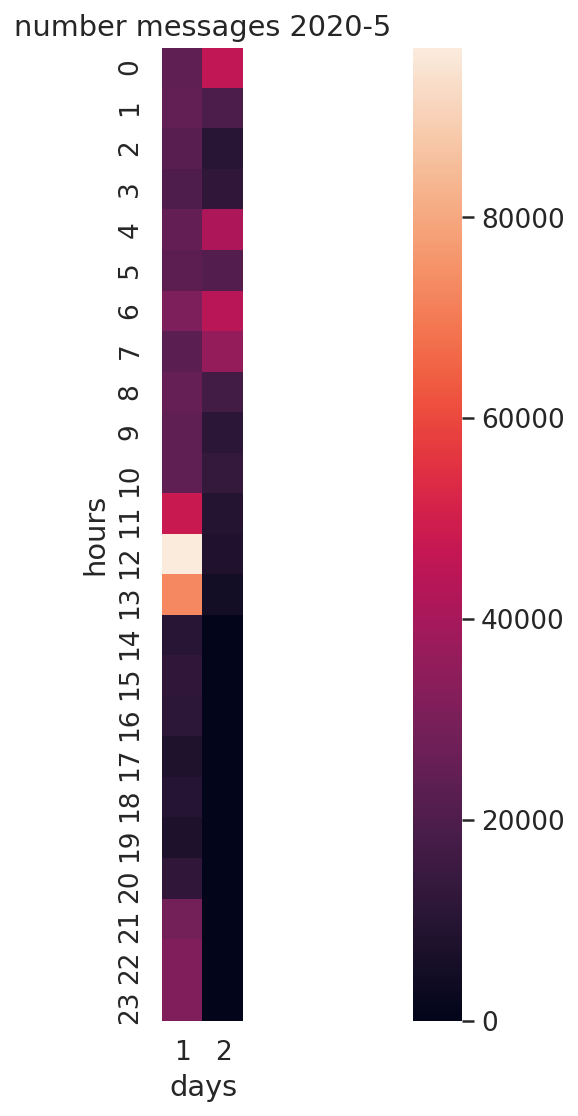

In [79]:
data2 = createData(pfall,7)
piv = pd.pivot_table(data2, values="outcome",index=["hours"], columns=["days"], fill_value=0)
#titlestring = "CSENDERENDPOINTID: " + str(topsender.iloc[7]['CSENDERENDPOINTID']) + ": "+ category + " so far = " + str(topsender.iloc[7]['outcome']) + " , month: " + str(month) 
#titlestring = "CSENDERENDPOINTID: " + str(topsender.iloc[7]['CSENDERENDPOINTID']) + ": "+ category  + " month: " + str(month) 
titlestring ="number messages 2020-5"
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
createHeatmap(piv, titlestring)

In [30]:
pfall = pd.read_parquet('/tmp/msgsenders_0702.parquet', engine='fastparquet')

In [49]:
#pfall = pfall.sort_values('CSTARTTIME').reset_index() 
pfall
#len (pfall)

,index,CSTARTTIME,CSENDERENDPOINTID,year,month,day,hour,minute
0,8376160,1572322159728,963,2019,10,29,5,9
1,9633350,1572322170795,1757,2019,10,29,5,9
2,8654824,1572322171388,1757,2019,10,29,5,9
3,5585396,1572322171483,1757,2019,10,29,5,9
4,17317315,1572322173962,2365,2019,10,29,5,9
...,...,...,...,...,...,...,...,...
27927974,27344700,1593690256275,973,2020,7,2,13,44
27927975,24690760,1593690258306,2157,2020,7,2,13,44
27927976,12679851,1593690259637,292,2020,7,2,13,44
27927977,16311331,1593690260506,2191,2020,7,2,13,44


# Time Series Anomaly Detection with LSTM Autoencoders (selected sender)

In [50]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [51]:
# functions

OUTCOME = 'close'

TIME_STEPS = 24
#TIME_STEPS = 30
#TIME_STEPS = 720
#TIME_STEPS = 168
#TIME_STEPS = 336

# setup data (current)
def createDataframe(pfall) :
    data3 = createData(pfall,0)
    df = pd.DataFrame()
    df[OUTCOME] = data3['outcome']
    df.set_index(data3['date'], inplace=True)
    return df

def getTrainAndTest(df,TRAIN_SIZE) :
    train_size = int(len(df) * TRAIN_SIZE)
    test_size = len(df) - train_size
    train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
    print("train.shape: ",train.shape, "test.shape: ", test.shape)
    return train, test

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

def initmodel():
    model = keras.Sequential()
    model.add(keras.layers.LSTM(
        units=64, 
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
    model.add(keras.layers.LSTM(units=64, return_sequences=True))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
    model.compile(loss='mae', optimizer='adam')
    return model

def testScoreDF(model, THRESHOLD) : 
    X_test_pred = model.predict(X_test)
    test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

    test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
    test_score_df['loss'] = test_mae_loss
    test_score_df['threshold'] = THRESHOLD
    test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
    test_score_df[OUTCOME] = test[TIME_STEPS:][OUTCOME]
    return test_score_df

In [52]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [138]:
#pd.unique(mdcountsall[1].index.get_level_values(0))
TOP=500000
result = pfall.groupby(['CSENDERENDPOINTID']).count()
data2 = pd.DataFrame()
data2['date'] = result.index.get_level_values(0).astype(str)
data2['outcome'] =  result['CSTARTTIME'].astype(int)
topsender =  data2[data2['outcome'] > TOP].sort_values('outcome').reset_index()
topsender.columns = ['index', 'CSENDERENDPOINTID', 'outcome']
topsender

,index,CSENDERENDPOINTID,outcome
0,1083,1082,532980.0
1,9,8,773133.0
2,1873,1872,821554.0
3,292,291,867884.0
4,998,997,925284.0
5,598,597,970345.0
6,1922,1921,974357.0
7,973,972,1264527.0
8,1512,1511,1820273.0
9,2191,2190,7007850.0


In [145]:
sender = 2191
pfall1 = pfall[pfall['CSENDERENDPOINTID'] == sender].sort_values('CSTARTTIME').reset_index() 

def get_datestr(row):
    return str(row.day) + "." + str(row.month) + "." + str(row.year) 


pfall1


,level_0,index,CSTARTTIME,CSENDERENDPOINTID,year,month,day,hour,minute
0,7,8376178,1572322183400,2191,2019,10,29,5,9
1,10,11171801,1572322185260,2191,2019,10,29,5,9
2,11,3770393,1572322185466,2191,2019,10,29,5,9
3,18,20947876,1572322216345,2191,2019,10,29,5,10
4,19,27792495,1572322217395,2191,2019,10,29,5,10
...,...,...,...,...,...,...,...,...,...
7007845,27927955,9185123,1593690235567,2191,2020,7,2,13,43
7007846,27927961,11003719,1593690245985,2191,2020,7,2,13,44
7007847,27927966,16729786,1593690249067,2191,2020,7,2,13,44
7007848,27927969,11701752,1593690251145,2191,2020,7,2,13,44


In [81]:
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10


In [74]:
#df1 = createDataframe(pfall1)
df1

,close
date,
2019-11-6-16,3
2019-11-6-17,4
2019-11-7-13,194
2019-11-12-14,84
2019-11-20-13,249
...,...
2020-7-2-9,226
2020-7-2-10,159
2020-7-2-11,119


In [146]:
df1 = createDataframe(pfall1)
train, test = getTrainAndTest(df1,0.95)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[[OUTCOME]])
train[OUTCOME] = scaler.transform(train[[OUTCOME]])
test[OUTCOME] = scaler.transform(test[[OUTCOME]])

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[[OUTCOME]], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[[OUTCOME]], test.close, TIME_STEPS)
print(X_train.shape)

model = initmodel()

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False)

X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

train.shape:  (5634, 1) test.shape:  (297, 1)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


(5610, 24, 1)
Epoch 1/10
158/158 [==============================] - 6s 36ms/step - loss: 0.4820 - val_loss: 0.4758
Epoch 2/10
158/158 [==============================] - 5s 31ms/step - loss: 0.4460 - val_loss: 0.4668
Epoch 3/10
158/158 [==============================] - 5s 30ms/step - loss: 0.4365 - val_loss: 0.4543
Epoch 4/10
158/158 [==============================] - 5s 30ms/step - loss: 0.4323 - val_loss: 0.4490
Epoch 5/10
158/158 [==============================] - 5s 31ms/step - loss: 0.4272 - val_loss: 0.4417
Epoch 6/10
158/158 [==============================] - 5s 29ms/step - loss: 0.4233 - val_loss: 0.4416
Epoch 7/10
158/158 [==============================] - 4s 28ms/step - loss: 0.4230 - val_loss: 0.4365
Epoch 8/10
158/158 [==============================] - 4s 28ms/step - loss: 0.4215 - val_loss: 0.4363
Epoch 9/10
158/158 [==============================] - 4s 27ms/step - loss: 0.4182 - val_loss: 0.4295
Epoch 10/10
158/158 [==============================] - 4s 28ms/step - loss: 0

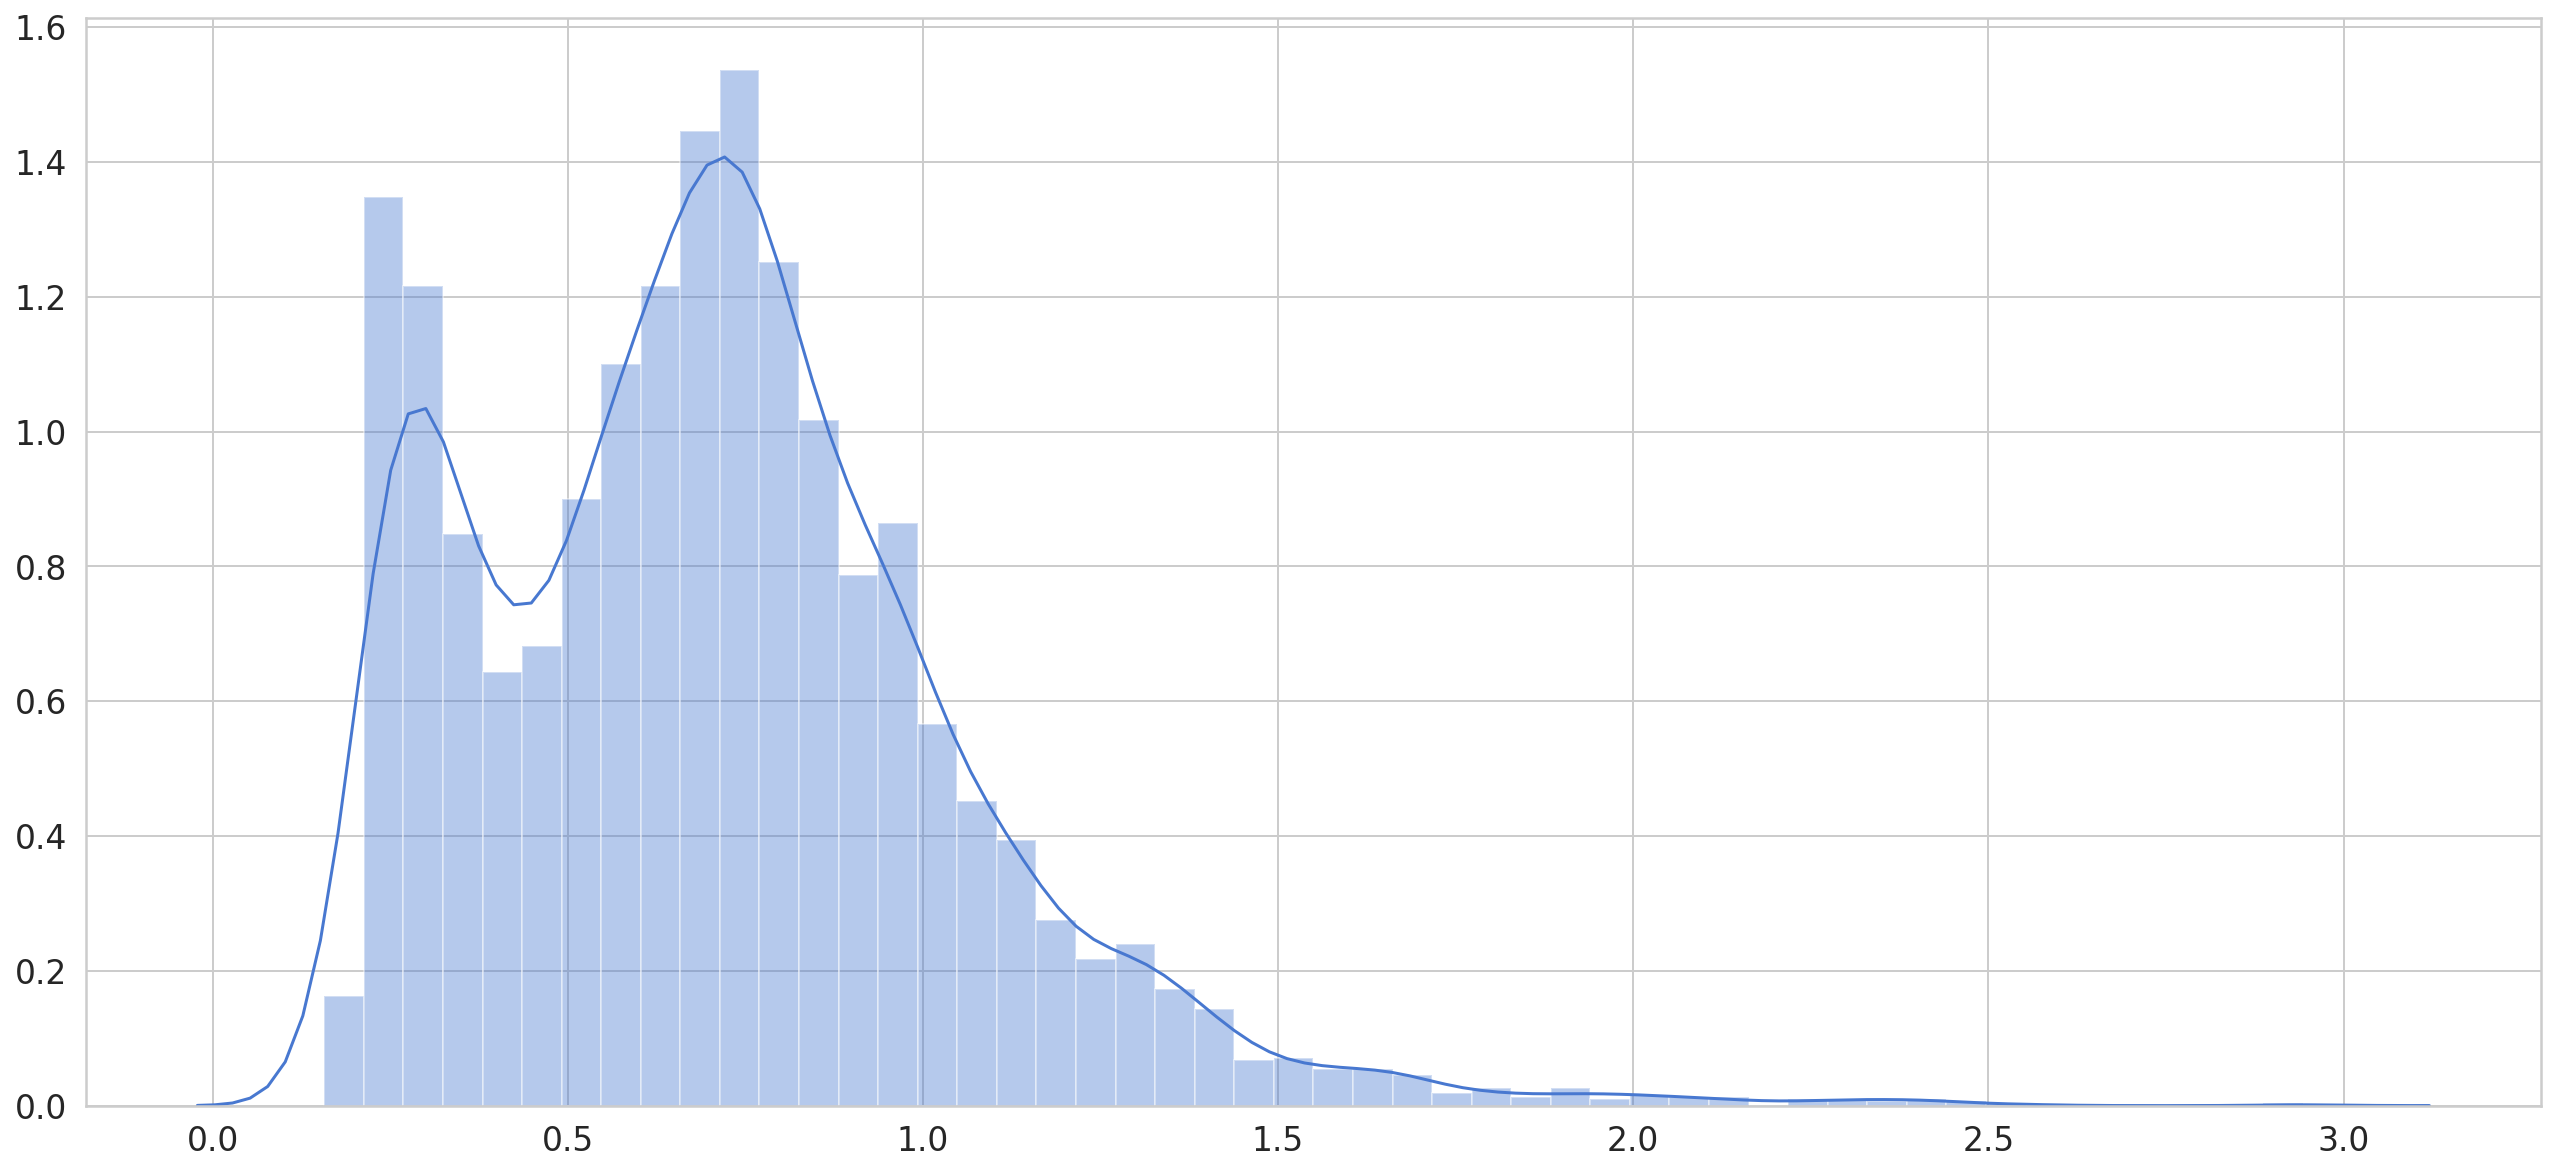

In [147]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [156]:
test_score_df = testScoreDF(model, 1.9)
anomalies     = test_score_df[test_score_df.anomaly == True]

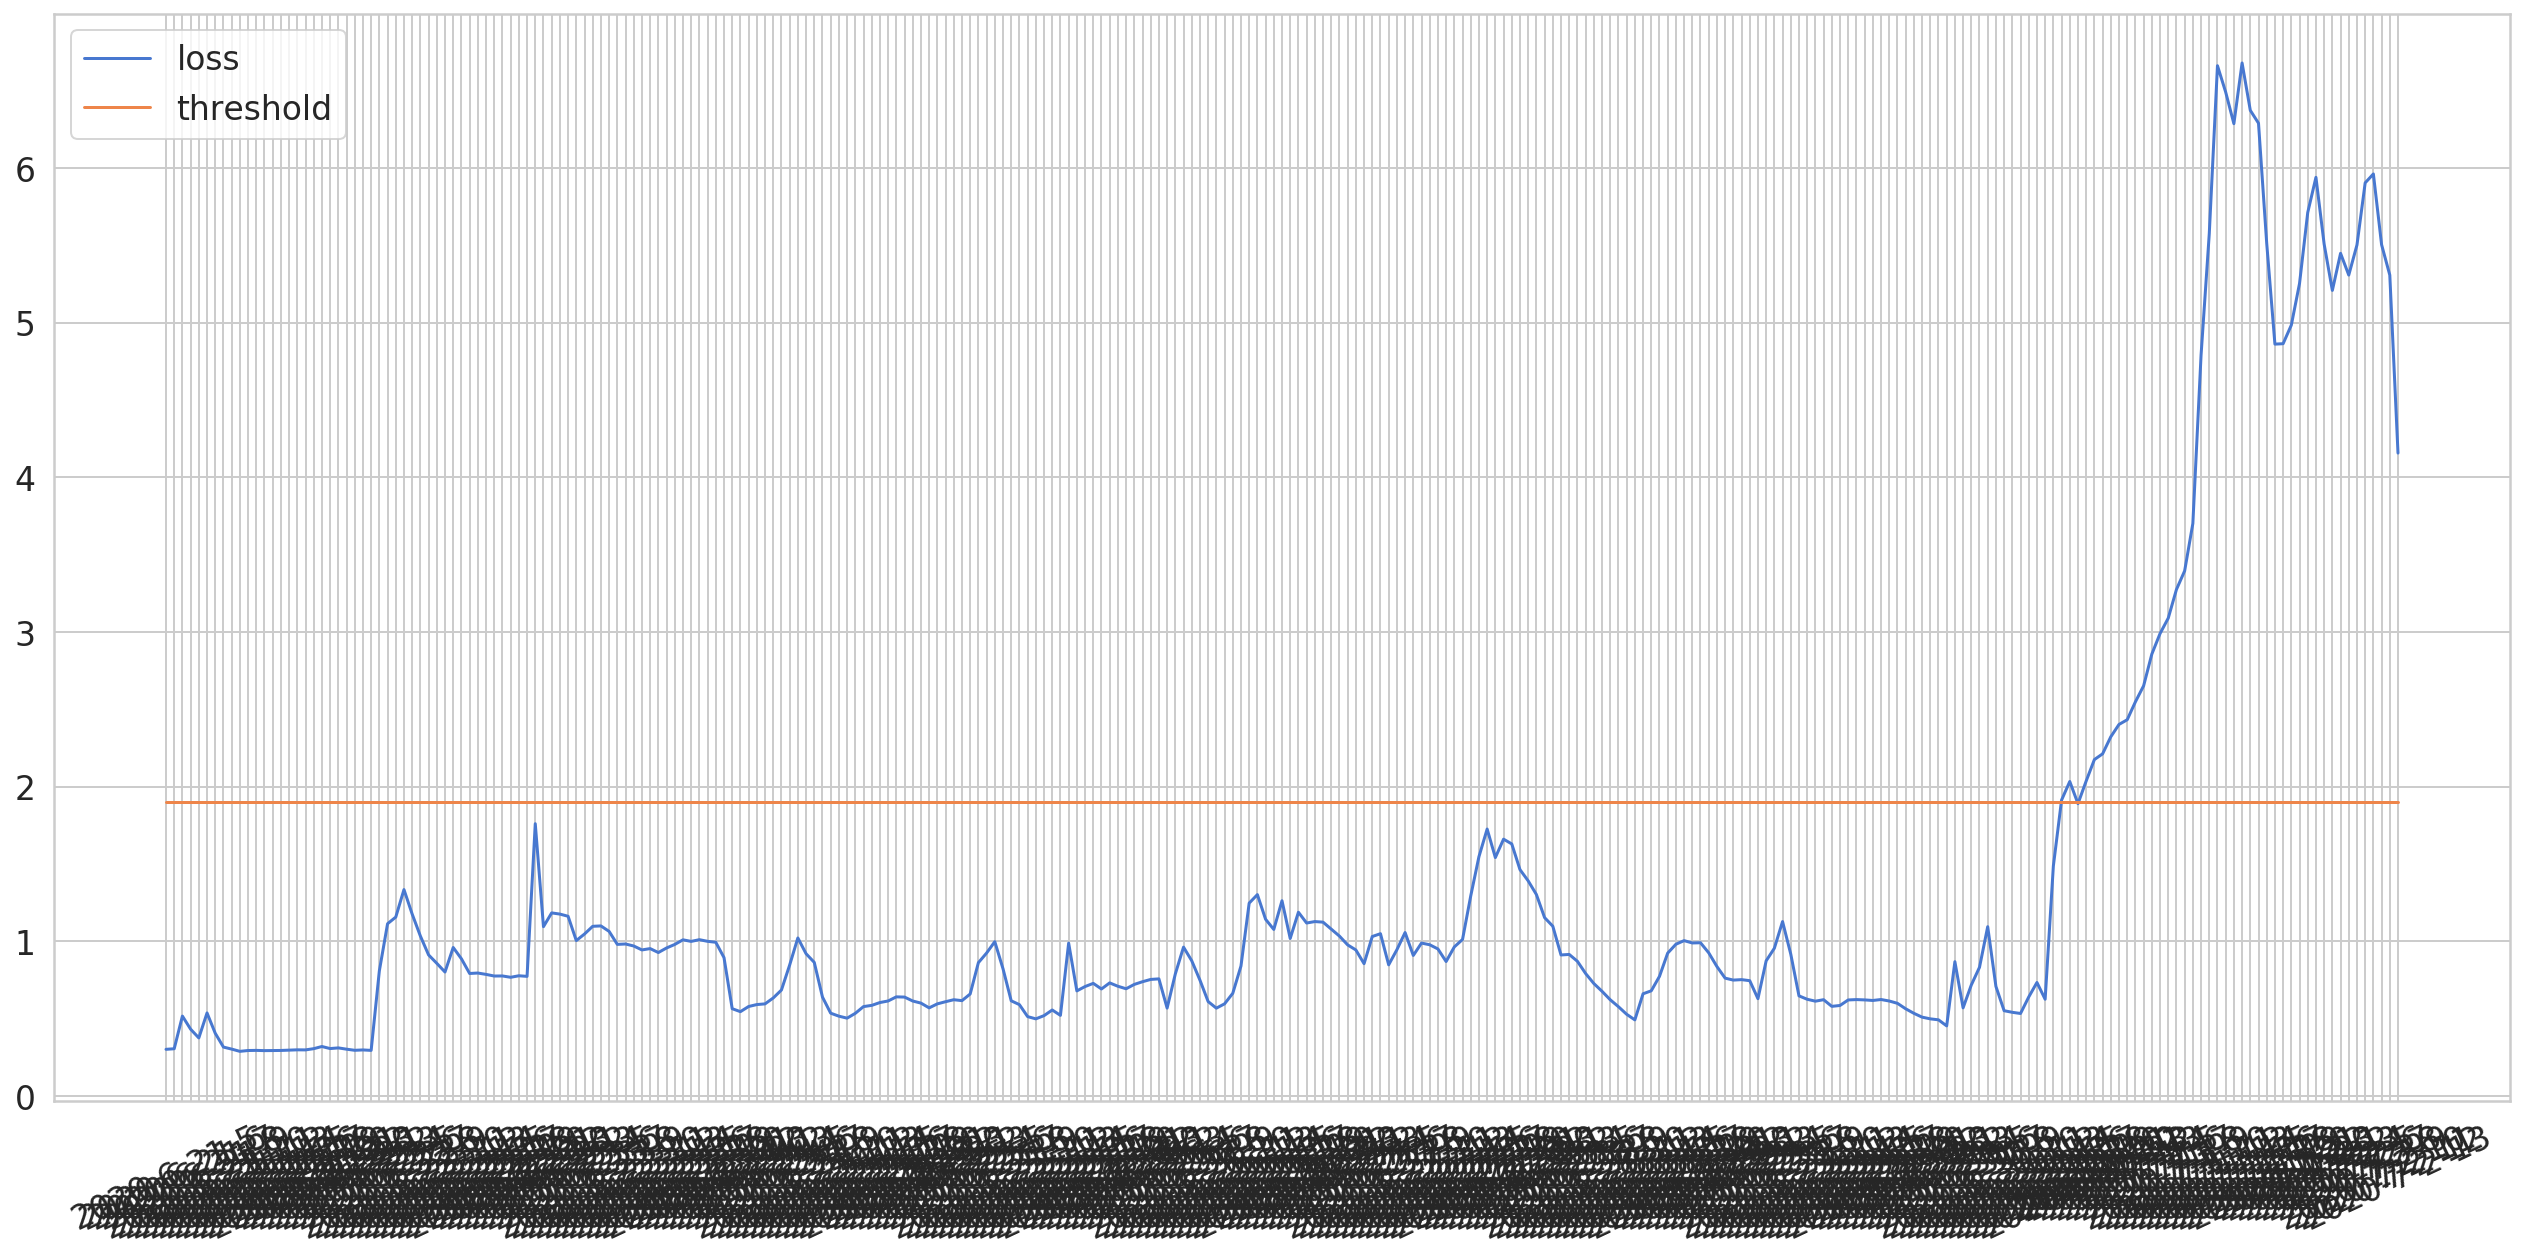

In [157]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

Text(0.5, 1.0, 'endpoint (sending) : 2191 ( trained: 2019-10-29-5 -- 2020-6-20-4 )')

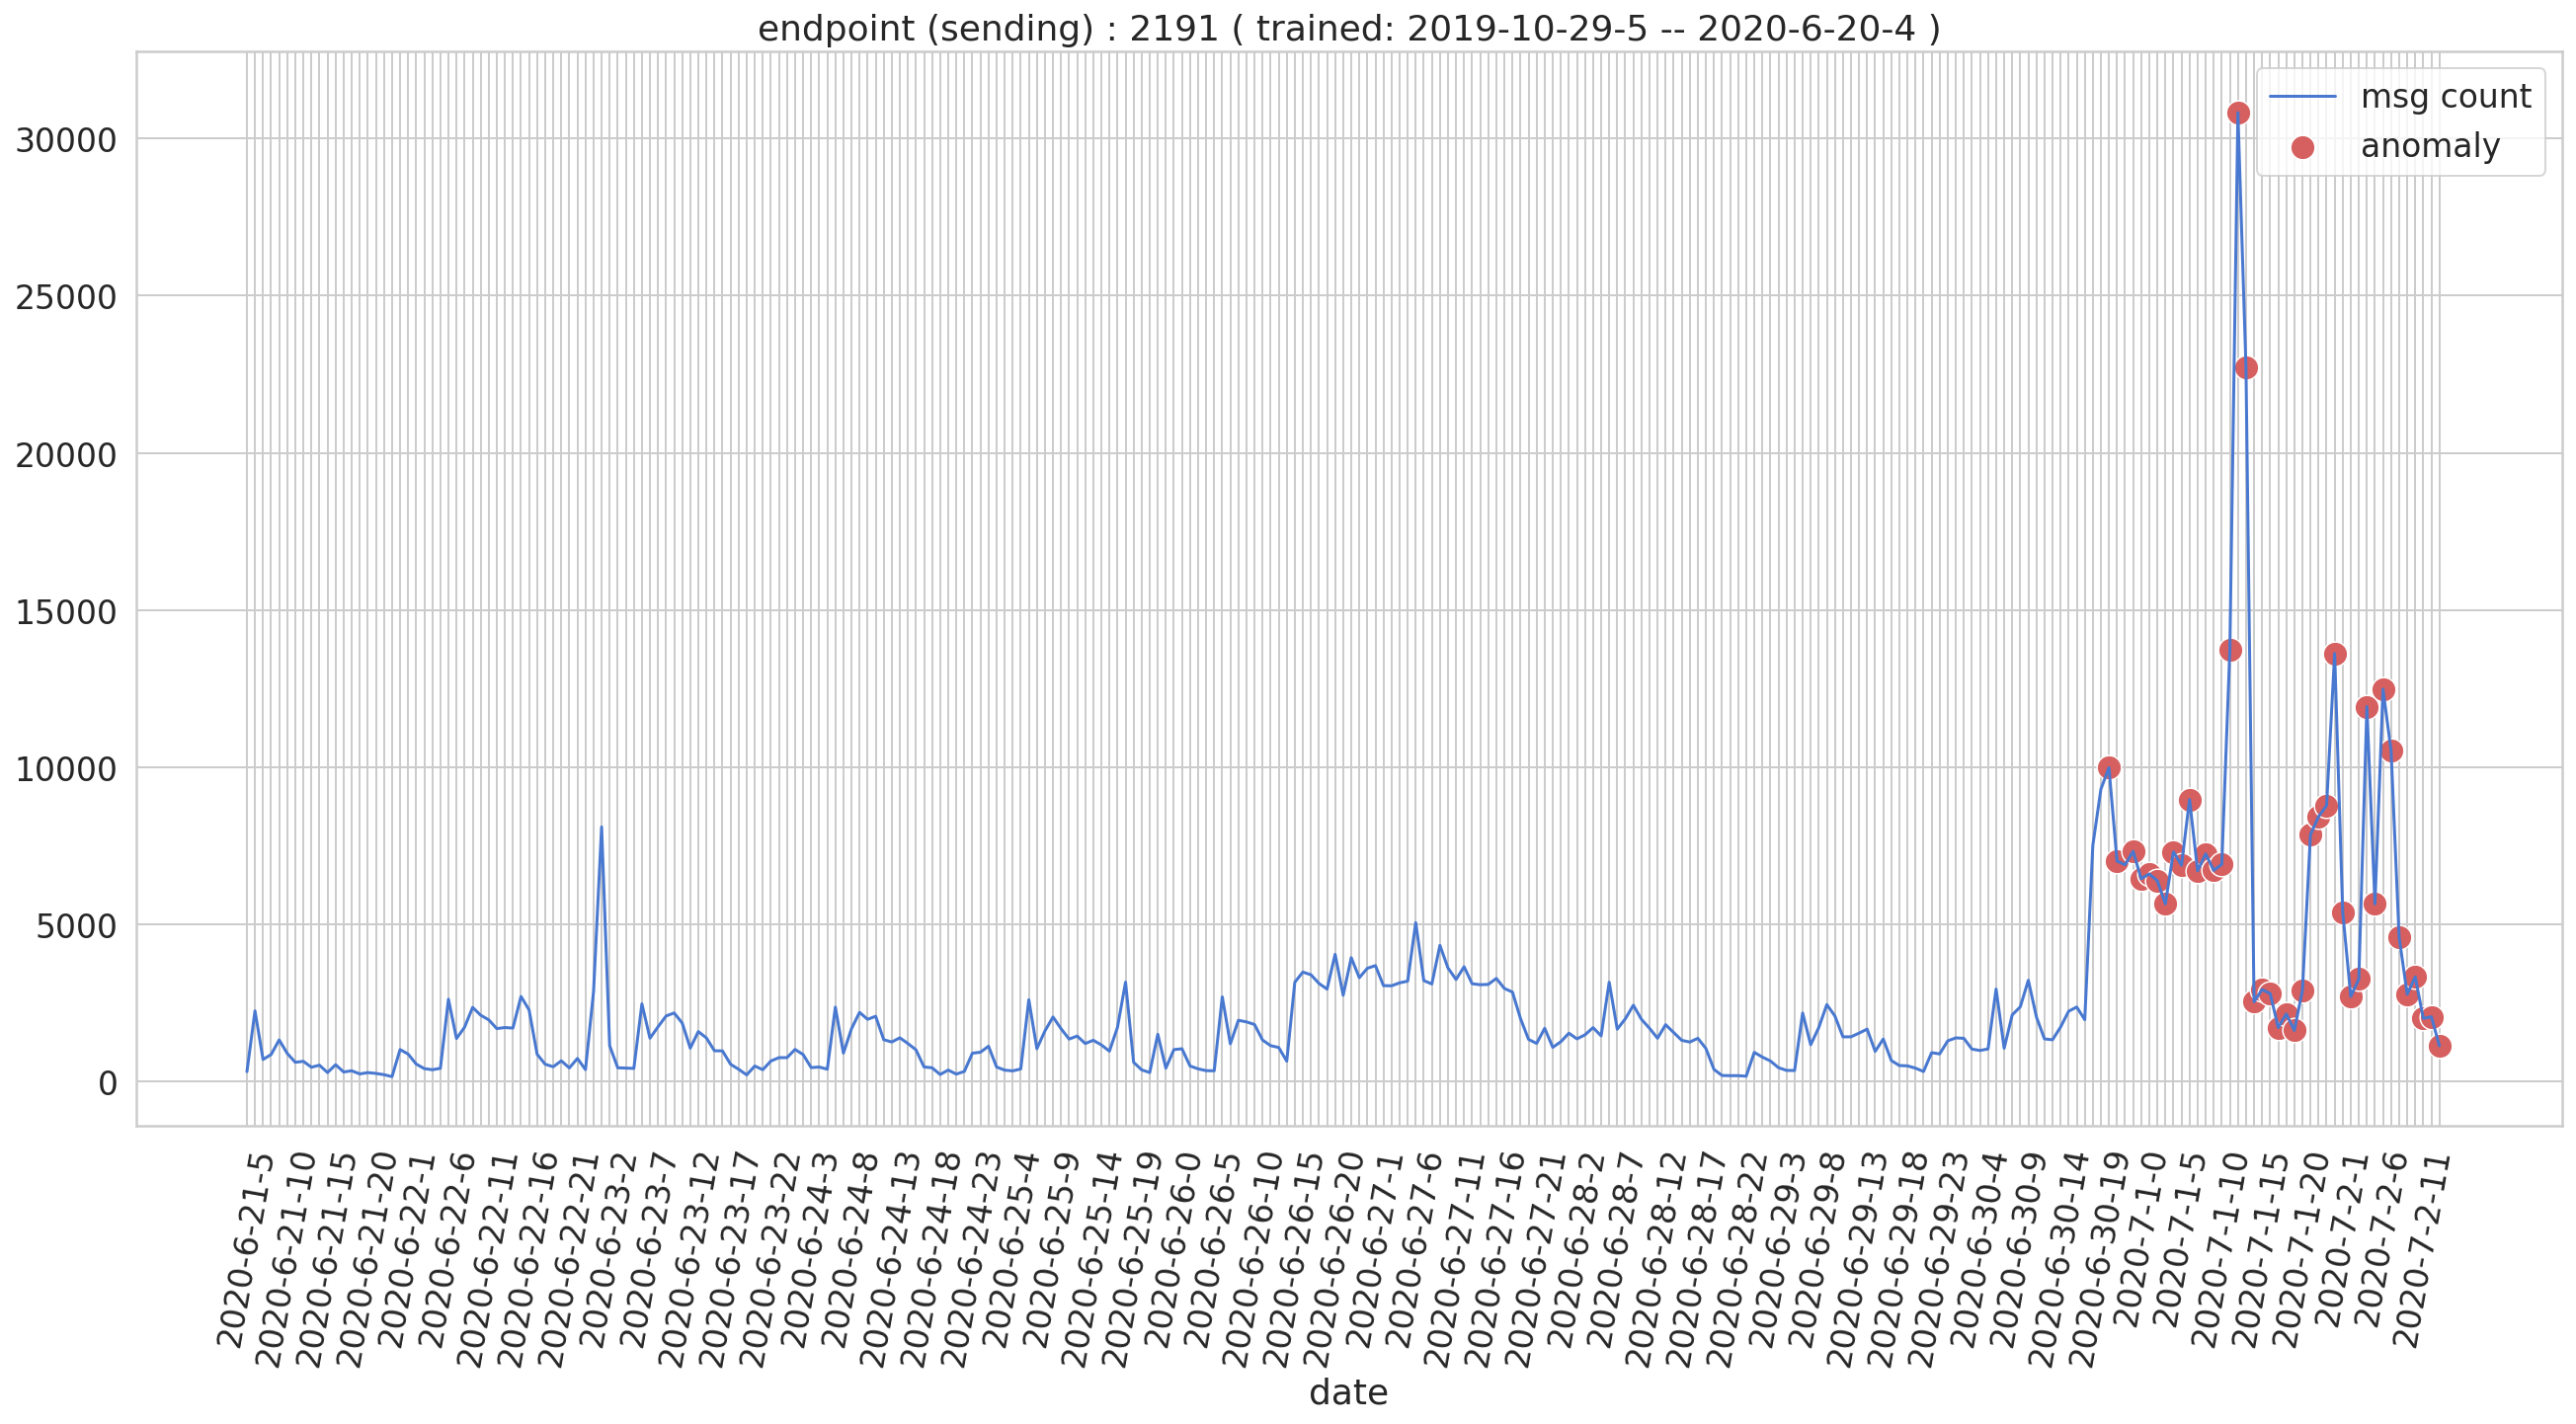

In [159]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close), 
  label='msg count'
);

ax = sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.close),
  color=sns.color_palette()[3],
  s=152,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();

label(ax,5,80)

titlestring ="endpoint (sending) : " + str(sender) + " ( trained: " +  train.index[0] + " -- " + train.index[len(train.index)-1] + " )"

plt.title(titlestring)

In [ ]:
#pfall[pfall['CSENDERENDPOINTID'] == 1774].reset_index().to_csv('/tmp/1774.csv', sep=';')
#pfall


# old

In [ ]:
len(pfall['CGLOBALMESSAGEID'].drop_duplicates())

In [ ]:
len(pfall['CGLOBALMESSAGEID'])

In [ ]:
pfall[pfall['CGLOBALMESSAGEID'] == '5ace4183-9e8f-11ea-b980-22fcac1e100b']
columns = df.limit(1).toPandas().columns
columns

In [ ]:
columns = df.limit(1).toPandas().columns
withoutColumns = ['timestamp', 'value','schemaid', 'hashvalue']
columns = columns[~columns.isin(withoutColumns)]

In [ ]:
#
schemas = dfcolumnSeries('schemaid').toPandas()['schemaid']
igroups = dfcolumnSeries('igroup').toPandas()['igroup']

schemaidCount  = dfcolumnCount('schemaid')
hashvalueCount = dfcolumnCount('hashvalue')
igroupCount = dfcolumnCount('igroup')
print('schemaidCount: ',schemaidCount,'hashvalueCount: ',hashvalueCount,'igroupCount: ',igroupCount)

In [ ]:
hashes = getIgroupHashes(6)

In [ ]:
_hash = hashes[10]
staticfeatureset = getStaticFeatures(_hash)

In [ ]:
relatedhashes = pd.unique(pfall[eval1(pfall)]['hashvalue'])
relatedhashes

In [ ]:
def getDataForRelatedHashes(relatedhashes):
    data2 = pd.DataFrame()
    start = True
    for hash_ in relatedhashes:
        c1 =  getDFvalueWithHash(int(hash_))
        if start:
            data2['date'] = c1['timestamp']
            start = False
        data2[str(hash_)] =  c1['value']
    return data2

In [ ]:
data = getDataForRelatedHashes(relatedhashes)
len(data)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#sns.lineplot(data=data2.iloc[:, :2])
sns.lineplot(data=data.iloc[:, 1:])

In [ ]:
data

In [ ]:
filteredrows = pfall[pfall['igroup'] == 6]

len(filteredrows)
hashes = pd.unique(filteredrows['hashvalue'])

In [ ]:
import numpy as np
getMissingSchemaids(pfall,hashes)

In [ ]:
data2 = pd.DataFrame()
#pfm = getDFvalueWithHash(int(relatedhashes[0]))
#
data2['date'] = dt['timestamp'].astype(str)
data2['value'] = dt['value']

In [ ]:
#hashes_d = dfcolumnSeries('hashvalue').toPandas()['hashvalue']
hashes_d = df.select(['hashvalue','schemaid']).dropDuplicates().toPandas()

In [ ]:
len(pd.unique(hashes_d['hashvalue']))


In [ ]:
#len(pd.unique(hashes_d))


dt = getDFvalueWithHash(int(hashes_d['schemaid'][0]),int(hashes_d['hashvalue'][0]))


In [ ]:
# check, if it is unique
len(dt['timestamp']), len(dt)

In [ ]:
len(pd.unique(pfall['hashvalue']))

In [ ]:
print(len(hashes))
len(pd.unique(pfall['hashvalue']))

In [ ]:
#getInfoForSchemas(filteredrows)
#len(pd.unique(filteredrows['__name__']))
#getEncoder('__name__').inverse_transform(pd.unique(filteredrows['__name__']))

In [ ]:
pfall[(pfall['schemaid'] == 1629035211) & (pfall['timestamp'] == 1587819506)]

In [ ]:
#getEncoder('igroup').inverse_transform(igroups)
for igroup in igroups:
    filteredrows = pfall[pfall['igroup'] == igroup]
    count = len(pd.unique(filteredrows['inode']))
    if count > 1:
        print(getEncoder('igroup').inverse_transform([igroup]),igroup,count)

In [ ]:
for hash_ in hashes:
    metric = filteredrows[filteredrows['hashvalue']==hash_]
    count = len(pd.unique(metric['value']))
    if count > 3:
        print(hash_,count)

In [ ]:
#continue with hash
#_hash=-2018833881
_hash=-283862276

In [ ]:
# !!!!!!!!!!! missing schemas
getMissingSchemaids(pfall)

In [ ]:
filteredrows[filteredrows['hashvalue'] == _hash]
filteredrows[filteredrows['hashvalue'] == _hash][featurecolumns].iloc[0]['__name__']

In [ ]:


#['schemaid','igroup']

#filteredrows[featurecolumns].head()
#getVariableUniqueColums(filteredrows[featurecolumns])

# there are still too many columns for _hash
#len(getVariableUniqueColums(filteredrows[featurecolumns]))
#len(featurecolumns)


# there are no variable columns left
#getVariableUniqueColums(filteredrows[filteredrows['hashvalue'] == _hash][featurecolumns])

# static feature values for metric _hash

#staticfeatureset[featurecolumns[1]]
#staticfeatureset


#featurecolumns

In [ ]:
currenthash     = int(relatedhashes[1])
currentfeatures = filteredrows[filteredrows['hashvalue'] == currenthash].iloc[0]
currentfeatures['igroup'],currentfeatures['inode'],currentfeatures['hashvalue'],getEncoder('__name__').inverse_transform([currentfeatures['__name__']])[0]

In [ ]:
pfm

In [ ]:
#data2 = data2.sort_values('date').reset_index()
c1

In [ ]:
data2

In [ ]:
ax = createLineplot(data2,16,10,1.4,title="",skip=500)
label(ax,10,90)

In [ ]:
data2.iloc[2]

In [ ]:
pfall.head()

In [ ]:
filteredrows[featurecolumns].head()

In [ ]:
# find out variable columns and type of value
#getVariableUniqueColums(pfm)
#selected = ['timestamp', 'value','year','month', 'day', 'hour', 'minute']

#which inode is used by metri hashvalue
used_inode = filteredrows[filteredrows['hashvalue'] == _hash]['inode'].iloc[0]

# other inodes for the igroup
inodes_igroup = pd.unique(filteredrows[filteredrows['igroup'] == 6]['inode'])
otherinodes = inodes_igroup[inodes_igroup!=used_inode]

#
pd.unique(filteredrows[filteredrows['igroup'] == 6]['__name__'])
pd.unique(filteredrows[(filteredrows['igroup'] == 6) & (filteredrows['__name__'] == 309)]['logical_system'])

In [ ]:
filteredrows[filteredrows['inode'] == inodes_igroup[0]]['hashvalue']


In [ ]:

        
metric = filteredrows[filteredrows['hashvalue']==_hash]
#metric = filteredrows[filteredrows['hashvalue']==hashes[0]]
#usedcolumns(metric)

keep = getVariableUniqueColums(metric)
#keepcolumns(dataall,keep)
#keep
len(metric),len(pd.unique(metric['value'])), pd.unique(metric['value'])
metric

In [ ]:
pfall1 = pfall[pfall['schemaid'] == schemas[0]]
mdcountsall = pfall1.groupby(['igroup','hashvalue'])
#['igroup'].count() 
#data2 = pd.DataFrame()
mdcountsall

In [ ]:
getEncoder('__name__').inverse_transform([pfall1.iloc[0]['__name__']])[0]

In [ ]:
def createData(pfall,month,outcome) :
    if outcome < 2 :
        mdcountsall = pfall[(pfall['month'] == month) & (pfall['outcome'] == outcome)].groupby(['year','month','day','hour'])['outcome'].count()
    else :
        if (month > 0) & (month < 13) :
            mdcountsall = pfall[(pfall['month'] == month)].groupby(['year','month','day','hour'])['outcome'].count()
        else :
            mdcountsall = pfall.groupby(['year','month','day','hour'])['outcome'].count()    
    a,b,c,d = get_ymdh(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ymdh_string(a,b,c,d)
    data2['outcome'] =  mdcountsall.reset_index()['outcome'].astype(int) 

    #for pivot table
    data2['hours'] =  d.astype(int) 
    data2['days']  =  c.astype(int) 
    piv = pd.pivot_table(data2, values="outcome",index=["hours"], columns=["days"], fill_value=0)
    return data2

In [ ]:
pfall.head()

In [ ]:
import os
os.environ['http_proxy'] = "http://172.30.12.56:3128" 
os.environ['https_proxy'] = "https://172.30.12.56:3128"   
#!conda install -y -c conda-forge fastparquet
!pip install tensorflow

# Rest

In [ ]:
FileSystem.get(sparkSession.hadoopConfiguration).listFiles('hdfs://172.30.17.145:8020/sla_sql_data/1580137124017', true)

#path.getFileSystem(sparkSession.hadoopConfiguration).listFiles(hdfs://172.30.17.145:8020/sla_sql_data/, true)

In [ ]:
from os import listdir
from os.path import isfile, join
mypath = 'hdfs://172.30.17.145:8020/sla_sql_data/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [ ]:
import esutil as eu
eu.hdfs.ls(hdfs_url='hdfs://172.30.17.145:8020/sla_sql_data/1580137124017', recurse=False, full=False)

In [ ]:
import os
os.environ['http_proxy'] = "http://172.30.12.56:3128" 
os.environ['https_proxy'] = "https://172.30.12.56:3128"   
!pip install hdfs

In [ ]:
!pip install esutil

In [ ]:
from hdfs import Config
client = Config().get_client('dev')
client.list('/*')

In [ ]:
from hdfs import Config
client = Config().get_client('dev')
mypath = 'hdfs://172.30.17.145:8020/sla_sql_data/1580137124017'
files = client.list(mypath)

In [ ]:
with open("/home/jovyan/.hdfscli.cfg", "w") as file:
    file.write("[global]\n") 
    file.write("default.alias = dev\n") 
    file.write("[dev.alias]\n") 
    file.write("url = https://172.30.17.145:8020\n") 
    file.write("user = admin\n") 